In [2]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'img_color')

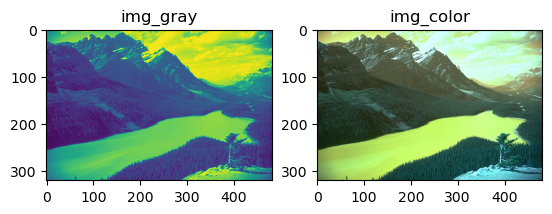

In [26]:
img_gray = cv2.imread('image2.jpg', cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread('image2.jpg')


plt.subplot(1, 2, 1)
plt.imshow(img_gray)        
plt.title("img_gray")

plt.subplot(1, 2, 2)
plt.imshow(img_color)        
plt.title("img_color")

In [29]:
noyau_x = np.array([[1, 0], [-1, 0]])
noyau_y = np.array([[1, -1], [0, 0]])

In [30]:
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [31]:
noyau2_x = np.array([[1, 0, 0], [0, 0, 0], [-1, 0, 0]])
noyau2_y = np.array([[1, 0, -1], [0, 0, 0], [0, 0, 0]])

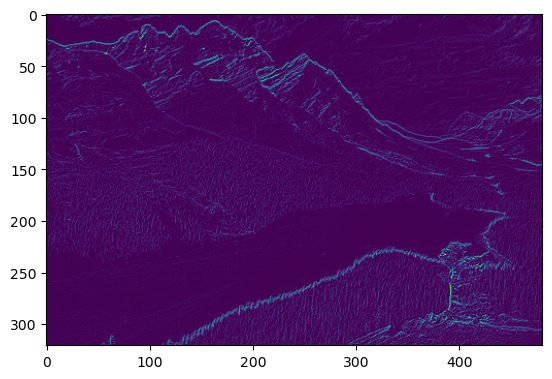

In [59]:
grad_x = cv2.filter2D(img_gray, -1, noyau_x)
grad_y = cv2.filter2D(img_gray, -1, noyau_y)

grad = np.hypot(grad_x, grad_y)
plt.imshow(grad)

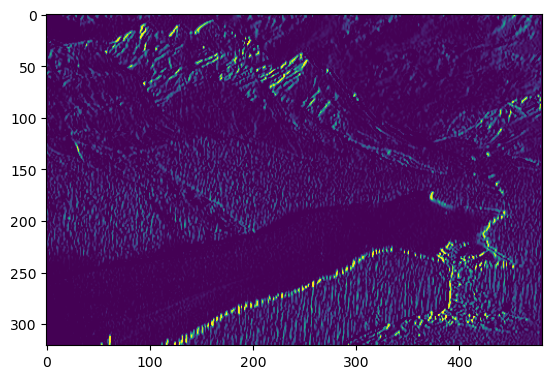

In [58]:
gradsobel_x = cv2.filter2D(img_gray, cv2.CV_8U, sobel_x)
gradsobel_y = cv2.filter2D(img_gray, cv2.CV_8U, sobel_y)

grad_sobel = np.hypot(gradsobel_x, gradsobel_y)
plt.imshow(gradsobel_x)

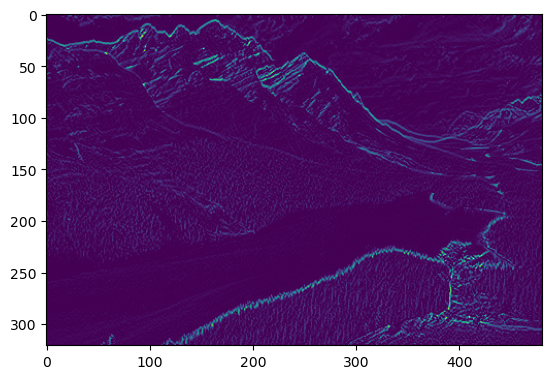

In [34]:
grad2_x = cv2.filter2D(img_gray, cv2.CV_8U, noyau2_x)
grad2_y = cv2.filter2D(img_gray, cv2.CV_8U, noyau2_y)

grad2 = np.hypot(grad2_x, grad2_y)
plt.imshow(grad2)

In [60]:
def sobel_x(img):
    n, m=img.shape
    gradx=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            gradx[i,j] = img[i-1,j+1] + 2*img[i,j+1] + img[i+1,j+1] - img[i-1,j-1] - 2*img[i,j-1] - img[i+1,j-1]
            
    return gradx
              

def sobel_y(img):
    n, m=img.shape
    grady=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            grady[i,j] = img[i-1,j-1] + 2*img[i-1,j] + img[i-1,j+1] - img[i+1,j-1] - 2*img[i+1,j] - img[i+1,j+1]
        
    return grady

def sobel(img):
    gradx, grady = sobel_x(img), sobel_y(img)
    return np.sqrt(gradx*gradx+grady*grady)

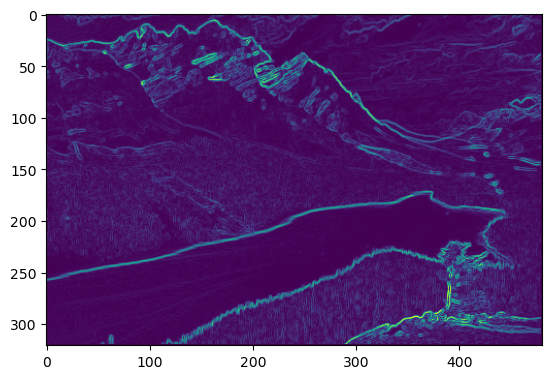

In [61]:
grad=sobel(img_gray)
plt.imshow(grad)

In [35]:
img=np.zeros((321, 481))
sigma=40

In [5]:
n, m = img.shape

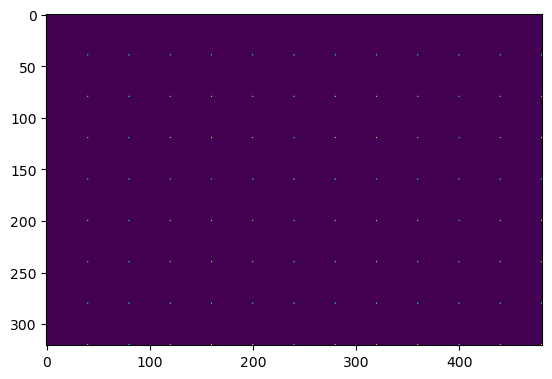

In [6]:
centers = np.zeros_like(img)
centers_coordinates = []
for i in range(0,n,sigma):
    for j in range(0,m,sigma):
        centers[i,j]=255
        centers_coordinates.append((i,j))
        
plt.imshow(img+centers)

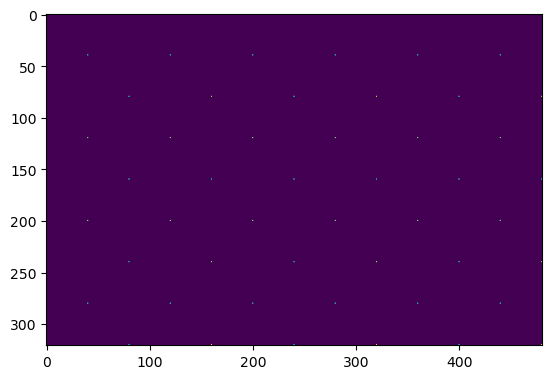

In [12]:
centers = np.zeros_like(img)
for i in range(0,n,sigma):
    if (i/sigma)%2==0:   
        for j in range(0,m,sigma*2):
            centers[i,j]=255
    else:
        for j in range(sigma,m,sigma*2):
            centers[i,j]=255
        
plt.imshow(img+centers)

In [7]:
def cell_centers(img, sigma, grid="square"):
    n, m = img.shape
    centers = np.zeros_like(img)
    centers_coordinates = []
    
    if grid=="square":
        for i in range(0,n,sigma):
            for j in range(0,m,sigma):
                centers[i,j]=255
                centers_coordinates.append((i,j))

    elif grid=="hexa":
        for i in range(0,n,sigma):
            if (i/sigma)%2==0:   
                for j in range(0,m,sigma*2):
                    centers[i,j]=255
            else:
                for j in range(sigma,m,sigma*2):
                    centers[i,j]=255
        
    return centers, centers_coordinates

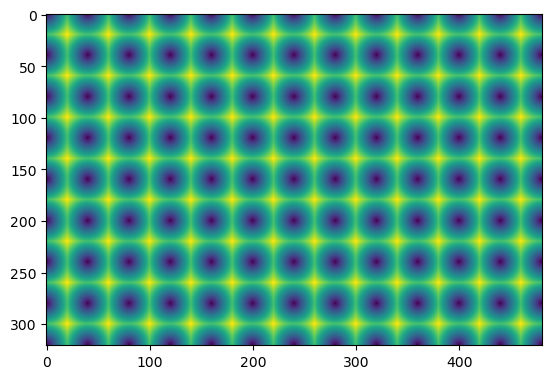

In [8]:
eucl_dist_map = np.zeros_like(img)
for i in range(n):
    for j in range(m):
        D=[]
        for c in centers_coordinates:
            (x, y)=c
            D.append(np.sqrt((x-i)**2+(y-j)**2))
        eucl_dist_map[i, j] = min(D)

plt.imshow(eucl_dist_map)

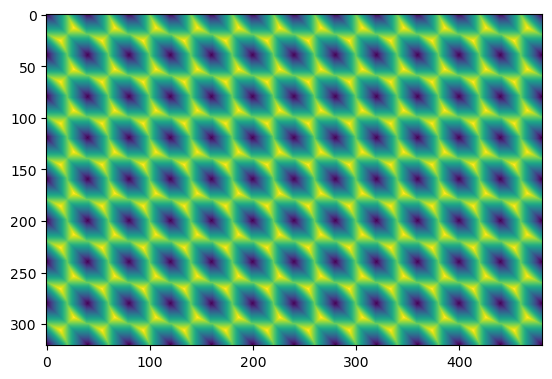

In [9]:
demi_masque = np.ones_like(img)*np.inf
for c in centers_coordinates:
    (i, j)=c
    demi_masque[i, j]=0

masque_avant=[(-1, -1, 1), (0, -1, 1), (-1, 0, 1), (-1, 1, 1), (0, 0, 0)]

for x in range(m):
    for y in range(n):
        C=[]
        for a in masque_avant:
            i, j, v = a
            if y+i<n and x+j<m and y+i>=0 and x+j>=0:
                C.append(demi_masque[y+i, x+j]+v)      
        demi_masque[y, x] = min(C)
        
masque_arriere=[(0,0,0), (1,-1,1), (1,0,1), (1,1,1), (0, 1,1)]

for x in range(m-1,-1,-1):
    for y in range(n-1,-1,-1):
        C=[]
        for a in masque_arriere:
            i, j, v = a
            if y+i<n and x+j<m and y+i>=0 and x+j>=0:
                C.append(demi_masque[y+i, x+j]+v)
        demi_masque[y, x] = min(C)
        
plt.imshow(demi_masque)

In [10]:
def carte_distance(img, centers_coordinates, masque_avant, masque_arriere):
    n, m = img.shape
    carte = np.ones_like(img)*np.inf
    for c in centers_coordinates:
        (i, j)=c
        carte[i, j]=0
        
    for x in range(m):
        for y in range(n):
            C=[]
            for a in masque_avant:
                i, j, v = a
                if y+i<n and x+j<m and y+i>=0 and x+j>=0:
                    C.append(carte[y+i, x+j]+v)      
            carte[y, x] = min(C)

    for x in range(m-1,-1,-1):
        for y in range(n-1,-1,-1):
            C=[]
            for a in masque_arriere:
                i, j, v = a
                if y+i<n and x+j<m and y+i>=0 and x+j>=0:
                    C.append(carte[y+i, x+j]+v)
            carte[y, x] = min(C)
    
    return carte

Text(0.5, 1.0, 'Carte de distance 2')

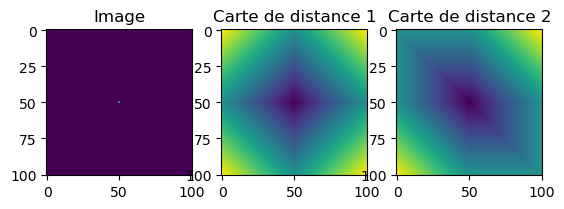

In [11]:
img=np.zeros((101,101))
centers_coordinates=[(50,50)]
for c in centers_coordinates:
    i, j=c
    img[i,j]=1

masque_avant1=[(-1, 0, 1), (0, -1, 1), (0, 0, 0)]
masque_arriere1=[(0,0,0), (1,0,1), (0, 1,1)]

masque_avant2=[(-1,-1,1), (0,-1,1), (-1,0,1), (-1,1,1), (0,0,0)]
masque_arriere2=[(0,0,0), (1,-1,1), (1,0,1), (1,1,1), (0,1,1)]

carte1=carte_distance(img, centers_coordinates, masque_avant1, masque_arriere1)
carte2=carte_distance(img, centers_coordinates, masque_avant2, masque_arriere2)

plt.subplot(1, 3, 1)
plt.imshow(img)        
plt.title("Image")

plt.subplot(1, 3, 2)
plt.imshow(carte1)        
plt.title("Carte de distance 1")

plt.subplot(1, 3, 3)
plt.imshow(carte2)        
plt.title("Carte de distance 2")

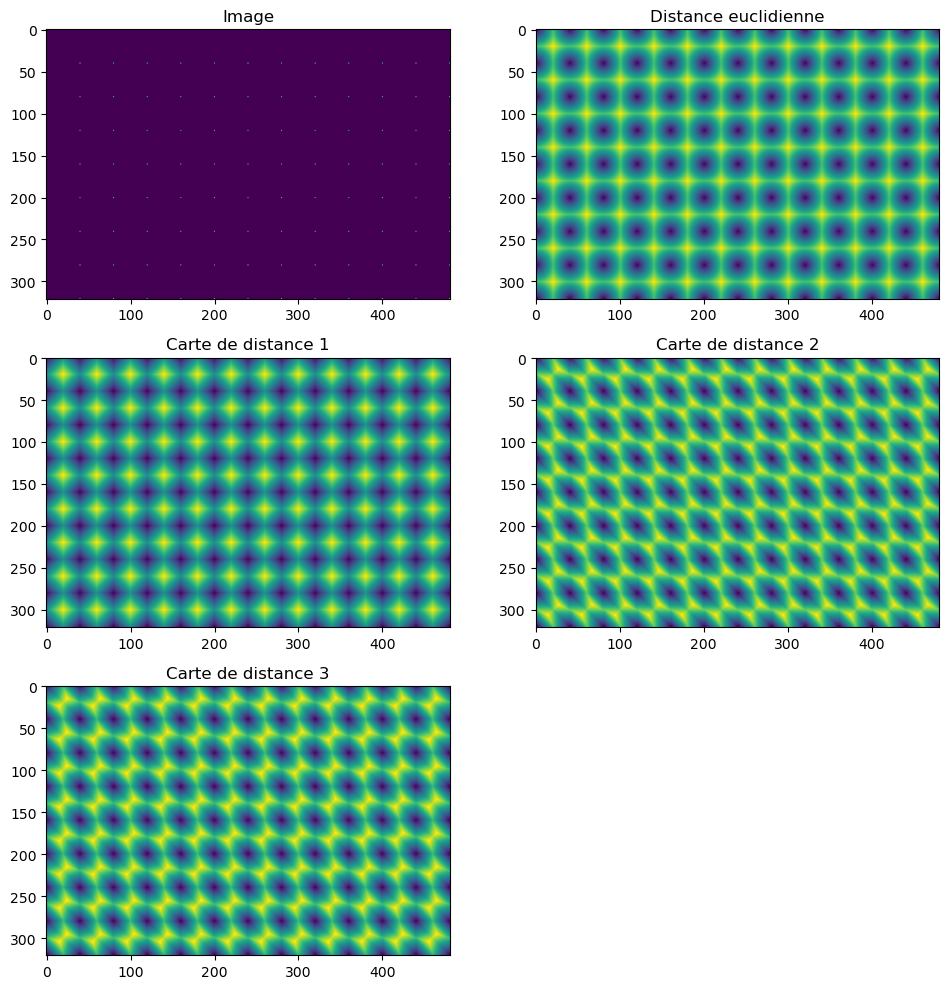

In [12]:
img=np.zeros((321, 481))
sigma=40
centers, centers_coordinates = cell_centers(img, sigma)
img=img+centers
        
masque_avant1=[(-1, 0, 1), (0, -1, 1), (0, 0, 0)]
masque_arriere1=[(0,0,0), (1,0,1), (0, 1,1)]

masque_avant2=[(-1,-1,1), (0,-1,1), (-1,0,1), (-1,1,1), (0,0,0)]
masque_arriere2=[(0,0,0), (1,-1,1), (1,0,1), (1,1,1), (0,1,1)]

masque_avant3=[(-1,-1,4), (0,-1,3), (-1,0,3), (-1,1,4), (0,0,0)]
masque_arriere3=[(0,0,0), (1,-1,4), (1,0,3), (1,1,4), (0,1,3)]

carte1=carte_distance(img, centers_coordinates, masque_avant1, masque_arriere1)
carte2=carte_distance(img, centers_coordinates, masque_avant2, masque_arriere2)
carte3=carte_distance(img, centers_coordinates, masque_avant3, masque_arriere3)

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(img)        
plt.title("Image")

plt.subplot(3, 2, 2)
plt.imshow(eucl_dist_map)        
plt.title("Distance euclidienne")

plt.subplot(3, 2, 3)
plt.imshow(carte1)        
plt.title("Carte de distance 1")

plt.subplot(3, 2, 4)
plt.imshow(carte2)        
plt.title("Carte de distance 2")

plt.subplot(3, 2, 5)
plt.imshow(carte3)        
plt.title("Carte de distance 3")

plt.tight_layout()

In [46]:
def seuillage(carte, p):
    m = np.max(carte)
    seuil = p*m
    carte_seuil = np.zeros_like(carte)
    n, m = carte.shape
    for i in range(n):
        for j in range(m):
            if carte[i, j] < seuil:
                carte_seuil[i, j]=1
            else:
                carte_seuil[i, j]=0
    return carte_seuil

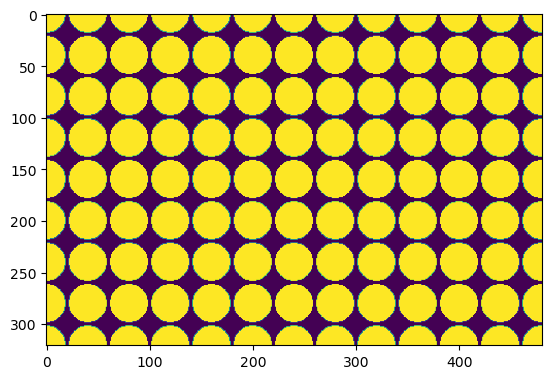

In [47]:
carte_seuil_eucl = seuillage(eucl_dist_map, 0.65)
plt.imshow(carte_seuil_eucl)

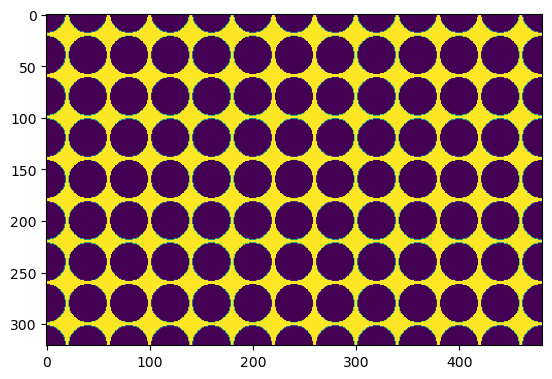

In [48]:
carte_seuil_eucl_inv = (carte_seuil_eucl+np.ones_like(carte_seuil_eucl))%2
plt.imshow(carte_seuil_eucl_inv)

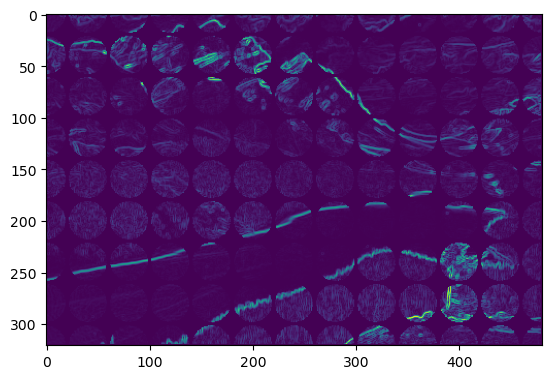

In [63]:
img_cellules=img_gray*carte_seuil_eucl
grad_cellules=grad*carte_seuil_eucl
plt.imshow(grad_cellules)

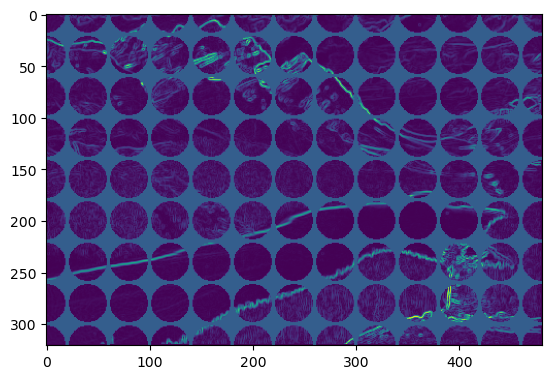

In [64]:
grad_cellules2=grad_cellules+255*carte_seuil_eucl_inv
plt.imshow(grad_cellules2)

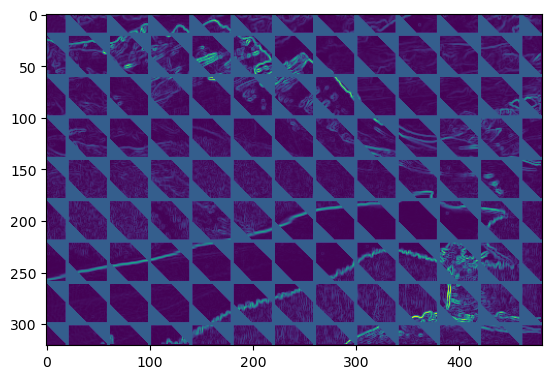

In [66]:
carte_seuil_2 = seuillage(carte2, 0.7)
carte_seuil_2_inv = (carte_seuil_2+np.ones_like(carte_seuil_2))%2

grad_cellules_carte2=grad*carte_seuil_2
grad_cellules_carte2_2=grad_cellules_carte2+255*carte_seuil_2_inv

plt.imshow(grad_cellules_carte2_2)